In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd as rsvd
rsvd.__name__ = "rsvd"

In [2]:
def svd_rank_experiment(X, func, ranks, *args, **kwargs):
    # No randomness, so no need for recomputation
    to = []
    eo = []
    
    t0 = time.perf_counter()
    U, s, Vh = func(X)
    t1 = time.perf_counter()
    
    for k in tqdm.tqdm(ranks):
        X_ = U[:, :k] * s[:k] @ Vh[:k]
        er = np.linalg.norm(X - X_)
        to.append(t1 - t0)
        eo.append(er)

    to = np.array(to).reshape(-1, 1)
    eo = np.array(eo).reshape(-1, 1)
    
    return rank_metrics(ranks, to, eo)

def rsvd_rank_experiment(X, func, ranks, n_trials: int = 5):
    to = []
    eo = []
    
    for k in tqdm.tqdm(ranks):
        ti = []
        ei = []
        
        for trial in range(n_trials):
            t0 = time.perf_counter()
            U, s, Vh = func(X, k)
            t1 = time.perf_counter()
            
            X_ = U[:, :k] * s[:k] @ Vh[:k]
            er = np.linalg.norm(X - X_)

            ti.append(t1 - t0)
            ei.append(er)
        
        to.append(ti)
        eo.append(ei)

    to = np.array(to)
    eo = np.array(eo)
    
    return rank_metrics(ranks, to, eo)

def rank_metrics(ranks, times, errors):
    metrics = {}
    metrics["rank"] = ranks
    metrics["time_avg"] = times.mean(axis=1)
    metrics["time_std"] = times.var(axis=1)
    metrics["error_avg"] = errors.mean(axis=1)
    metrics["error_std"] = errors.var(axis=1)
    return metrics

## Experiment 1: Low-rank approximation of a fixed matrix

In [3]:
%%time

# Run experiment over many ranks
np.random.seed(42)

ranks = np.linspace(100, 1000, num=10, dtype=int) # NOTE: This is small for testing purposes, real deal should be at least 2 order magnitude greater
n = ranks[-1]
X = np.random.normal(0, 1, (n, n))
n_trials = 10 # TODO: Possibly can remove since various is insignificant
print("Matrix:", X.shape, "ranks:", ranks, "n_trials:", n_trials)

measures = ["error", "time", "speedup"]
methods = []

# Exact 
f = np.linalg.svd
metrics = {}
metrics["name"] = [f.__name__] * len(ranks)
func = lambda x: f(x, full_matrices=False)
metrics = {**metrics, **svd_rank_experiment(X, func, ranks, n_trials)}
metrics["speedup_avg"] = metrics["time_avg"] / metrics["time_avg"]
metrics["speedup_std"] = 0 * metrics["speedup_avg"]
methods.append(metrics)

# Approximate
f = rsvd
metrics = {}
metrics["name"] = [f.__name__ + " (n_oversamples=0,n_iter=0)"] * len(ranks)
func = lambda x, k: f(x, k, n_oversamples=0, n_iter=0) # last two params speed-accuracy tradeoff
metrics = {**metrics, **rsvd_rank_experiment(X, func, ranks, n_trials)}
metrics["speedup_avg"] = methods[0]["time_avg"] / metrics["time_avg"]
metrics["speedup_std"] = 0 * metrics["speedup_avg"]
methods.append(metrics)

f = rsvd
metrics = {}
metrics["name"] = [f.__name__ + " (n_oversamples=10,n_iter=0)"] * len(ranks)
func = lambda x, k: f(x, k, n_oversamples=10, n_iter=0) # last two params speed-accuracy tradeoff
metrics = {**metrics, **rsvd_rank_experiment(X, func, ranks, n_trials)}
metrics["speedup_avg"] = methods[0]["time_avg"] / metrics["time_avg"]
metrics["speedup_std"] = 0 * metrics["speedup_avg"]
methods.append(metrics)

f = rsvd
metrics = {}
metrics["name"] = [f.__name__ + " (n_oversamples=0,n_iter=1)"] * len(ranks)
func = lambda x, k: f(x, k, n_oversamples=0, n_iter=1) # last two params speed-accuracy tradeoff
metrics = {**metrics, **rsvd_rank_experiment(X, func, ranks, n_trials)}
metrics["speedup_avg"] = methods[0]["time_avg"] / metrics["time_avg"]
metrics["speedup_std"] = 0 * metrics["speedup_avg"]
methods.append(metrics)

Matrix: (1000, 1000) ranks: [ 100  200  300  400  500  600  700  800  900 1000] n_trials: 10


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

CPU times: user 48.4 s, sys: 8.81 s, total: 57.2 s
Wall time: 40.9 s


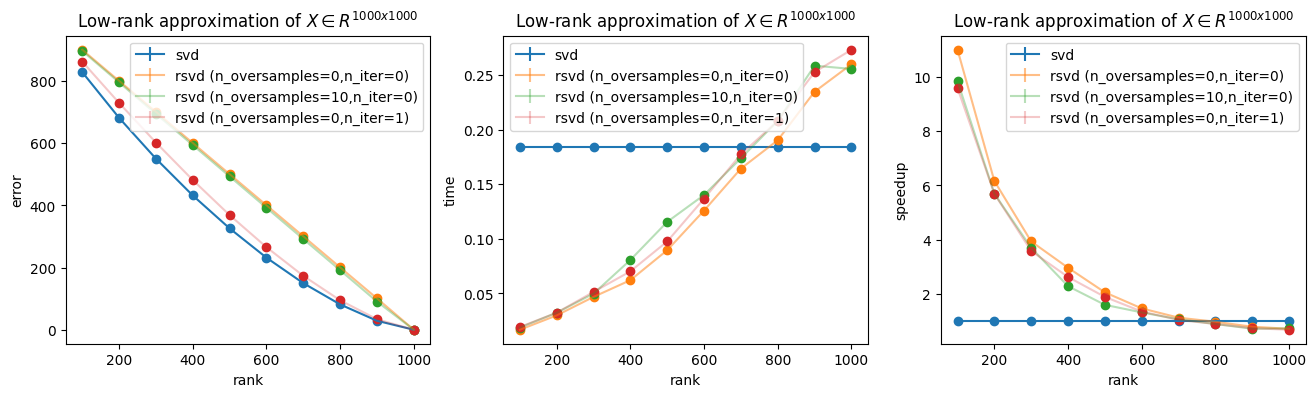

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for i, measure in enumerate(measures):
    for j, metrics in enumerate(methods):
        ax[i].errorbar(ranks, metrics[f"{measure}_avg"], metrics[f"{measure}_std"], label=metrics["name"][0], alpha=1/(j+1))
        ax[i].scatter(ranks, metrics[f"{measure}_avg"])

    ax[i].set_title(f"Low-rank approximation of $X \\in R^{{{n}x{n}}}$")
    ax[i].set_xlabel("rank")
    ax[i].set_ylabel(measure)
    ax[i].legend()
    
plt.show()

In [5]:
df = pd.DataFrame(methods)
df = df.explode(df.columns.tolist())
df

,name,rank,time_avg,time_std,error_avg,error_std,speedup_avg,speedup_std
0,svd,100,0.183755,0.0,828.336423,0.0,1.0,0.0
0,svd,200,0.183755,0.0,681.318158,0.0,1.0,0.0
0,svd,300,0.183755,0.0,550.10497,0.0,1.0,0.0
0,svd,400,0.183755,0.0,431.755695,0.0,1.0,0.0
0,svd,500,0.183755,0.0,325.941131,0.0,1.0,0.0
0,svd,600,0.183755,0.0,231.696034,0.0,1.0,0.0
0,svd,700,0.183755,0.0,149.789119,0.0,1.0,0.0
0,svd,800,0.183755,0.0,81.375658,0.0,1.0,0.0
0,svd,900,0.183755,0.0,28.824422,0.0,1.0,0.0
0,svd,1000,0.183755,0.0,0.0,0.0,1.0,0.0


## Experiment 2: Low-rank approximation of different matrix scales

In [6]:
# Run experiment over many sizes
np.random.seed(42)

# Xs = [
#     np.random.normal(0, 1, (n, n)),
#     np.random.normal(0, 1, (n, n)),
#     ...
#     np.random.normal(0, 1, (n, n)),
# ]

## Experiment 3: rSVD Hyperparameters

In [7]:
# Experiments demonstrating impact of parameters on runtime and accuracy (which depend on properties of data)
# Requires reviewing https://arxiv.org/abs/0909.4061
# above is theoretical justification
# and https://github.com/scikit-learn/scikit-learn/blob/6bf2061f7/sklearn/utils/extmath.py#L524C3-L530C6
# above is basically the meat of the implementation

# NOTE: Method is best when high-dimensional data exhibits primarily low-dimensional structure (has been empirically shown for real-world datasets)

# Some applications only care about svd to reduce matmul ops. 
# Can we use rank approx rsvd to save in both decomposition time and matmul ops without too much loss in quality?

# Relevant implementations
# https://scikit-learn.org/dev/modules/generated/sklearn.utils.extmath.randomized_svd.html
# https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.TruncatedSVD.html